In [1]:
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import pandas as pd


import numpy as np

# filenames = ["Turb_SouthCarolina_S2_st1.csv", 
#              "Turb_SouthCarolina_S2_st2.csv", 
#              "Turb_SouthCarolina_S2_st3.csv", 
#              "Turb_SouthCarolina_S2_st4.csv", 
#              "Turb_SouthCarolina_S2_st5.csv", 
#              "Turb_SouthCarolina_S2_st6.csv", 
#              "Turb_SouthCarolina_S2_st7.csv", 
#              "Turb_SouthCarolina_S2_st8.csv", 
#              "Turb_SouthCarolina_S2_st9.csv",
#              "Turb_Louisiana_S2_st1.csv", 
#              "Turb_Louisiana_S2_st2.csv", 
#              "Turb_Louisiana_S2_st3.csv", 
#              "Turb_Louisiana_S2_st4.csv", 
#              "Turb_Louisiana_S2_st5.csv", 
#              "Turb_Louisiana_S2_st6.csv",
#              "Turb_Mat_S2_st1.csv", 
#              "Turb_Mat_S2_st2.csv",
#              "Turb_Houston_S2_st1.csv", 
#              "Turb_Houston_S2_st2.csv", 
#              "Turb_Houston_S2_st3.csv",
#              "Turb_Phil_S2_st1.csv", 
#              "Turb_Phil_S2_st2.csv"]

# filenames = ["Turb_Houston_S2_st1.csv", 
#              "Turb_Houston_S2_st2.csv", 
#              "Turb_Houston_S2_st3.csv"]

# filenames = ["Turb_Louisiana_S2_st1.csv", 
#             "Turb_Louisiana_S2_st2.csv", 
#             "Turb_Louisiana_S2_st3.csv", 
#             "Turb_Louisiana_S2_st4.csv", 
#             "Turb_Louisiana_S2_st5.csv", 
#             "Turb_Louisiana_S2_st6.csv"]

filenames = ["Turb_Louisiana_L8_st1.csv", 
             "Turb_Louisiana_L8_st2.csv", 
             "Turb_Louisiana_L8_st3.csv", 
             "Turb_Louisiana_L8_st4.csv", 
             "Turb_Louisiana_L8_st5.csv", 
             "Turb_Louisiana_L8_st6.csv",
             "Turb_Louisiana_L9_st1.csv", 
             "Turb_Louisiana_L9_st2.csv", 
             "Turb_Louisiana_L9_st3.csv", 
             "Turb_Louisiana_L9_st4.csv", 
             "Turb_Louisiana_L9_st5.csv", 
             "Turb_Louisiana_L9_st6.csv"]

# filenames = ["Turb_Houston_L8_st1.csv", 
#              "Turb_Houston_L8_st2.csv", 
#              "Turb_Houston_L8_st3.csv",
#              "Turb_Houston_L9_st1.csv", 
#              "Turb_Houston_L9_st2.csv", 
#              "Turb_Houston_L9_st3.csv"]

parameter = 'nearest_turbidity'

# bands_columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'] # For S2
bands_columns = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'] #For Landsats

x = []
y = []
site_number = []
dates = []
satellite = []
doy = []

for filename in filenames:

    data = pd.read_csv(filename)
    x.append(data[bands_columns].to_numpy())
    y.append(data[parameter].to_numpy())
    site_number.append(data["site_no"].to_list())
    dates.append(data["ImageAquisition_time"].to_list())
    satellite.append(data["spacecraft_name"].to_list())
    doy.append(data["doy"].to_numpy())

x = np.vstack(x)
y = np.concatenate(y)
doy = np.concatenate(doy)

site_number = [item for sublist in site_number for item in sublist]
dates = [item for sublist in dates for item in sublist]
satellite = [item for sublist in satellite for item in sublist]

print('data_total,' , y.shape)

data_total, (490,)


In [2]:
def log_scale_transform(X, Y, doy, site_number, dates, satellites):
    
    shift_value_X = np.abs(np.min(X)) + 1  # Shift X to ensure positive values
    shift_value_Y = np.abs(np.min(Y)) + 1  # Shift Y similarly
    
    X_shifted = X + shift_value_X
    Y_shifted = Y + shift_value_Y
    
    X_log = np.log(X_shifted)
    Y_log = np.log(Y_shifted)

    s1 = np.arange(X_log.shape[0])
    np.random.shuffle(s1)
    X_log = X_log[s1, :]
    Y_log = Y_log[s1]
    
    doy_new = doy[s1]
    site_number_new = [site_number[i] for i in s1]
    dates_new = [dates[i] for i in s1]
    satellites_new = [satellites[i] for i in s1]
    
    transformerX = RobustScaler().fit(X_log)
    X_trans = transformerX.transform(X_log)
    min_max_scalerX = MinMaxScaler().fit(X_trans)
    X_trans2 = min_max_scalerX.transform(X_trans)

    transformerY = RobustScaler().fit(np.reshape(Y_log,(-1,1)))
    Y_trans = transformerY.transform(np.reshape(Y_log,(-1,1)))
    min_max_scalerY = MinMaxScaler().fit(Y_trans)
    Y_trans2 = min_max_scalerY.transform(Y_trans)

    return X_trans2, Y_trans2, transformerX, transformerY, min_max_scalerX, min_max_scalerY, shift_value_X, shift_value_Y, doy_new, site_number_new, dates_new, satellites_new, s1

def r_squared(y, y_hat):
 ''' Logarithmic R^2 '''
 slope_, intercept_, r_value, p_value, std_err = stats.linregress(y, y_hat)
 return r_value**2 * 100

def mape_function(y, y_hat):
 ''' Mean Absolute Percentage Error '''
 return 100 * np.mean(np.abs((y - y_hat) / y))

def ytest_to_initial_scale(ytest, min_max_scalerY_turb, transformerY_turb, shift_value_Y):
    ytest_inv1 = min_max_scalerY_turb.inverse_transform(np.reshape(ytest, (-1, 1)))
    ytest_inv2 = transformerY_turb.inverse_transform(ytest_inv1)
    ytest_inv2 = np.exp(ytest_inv2)
    ytest_rescaled = ytest_inv2 - shift_value_Y - 1
    return ytest_rescaled

In [3]:
### For Turb values S2

# index = y<=150
# y = y[index]
# x = x[index, :]

### For WQEyey paper Mostafa

index = y<=100
y = y[index]
x = x[index, :]

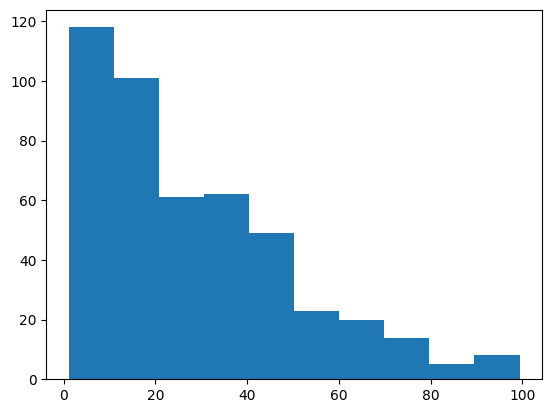

In [4]:
import matplotlib.pyplot as plt
plt.hist(y);

In [5]:
x_rescaled, y_rescaled, transformerX, transformerY, min_max_scalerX, min_max_scalerY, shift_value_X, shift_value_Y, doy_new, site_number_new, dates_new, satellite_new, s1 = log_scale_transform(x, y, doy, site_number, dates, satellite)

y_rescaled = np.squeeze(y_rescaled)

print('data_total,' , y_rescaled.shape)
print('min,' ,np.min(y_rescaled))
print('max,' ,np.max(y_rescaled))
print('mean,' ,np.mean(y_rescaled))
print('std,' ,np.std(y_rescaled))

data_total, (461,)
min, 0.0
max, 1.0
mean, 0.572557065539999
std, 0.22346204505372783


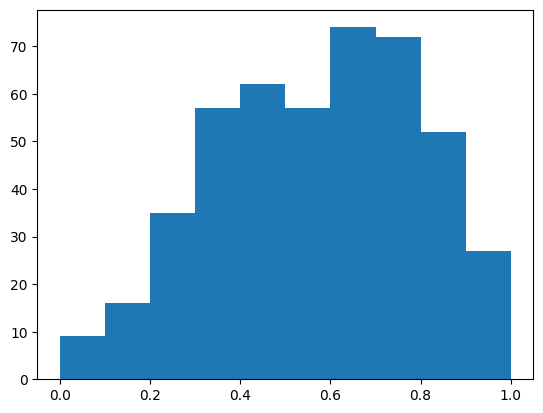

In [6]:
import matplotlib.pyplot as plt
plt.hist(y_rescaled);

In [7]:
#### We have to consider to approaches: 1- for getting MDN inputs, 2- for getting direct RS reflectance
# '''
#     1: 5-fold validation for hyperparameter tuning on training data
#     2: hyperparameter tuning using the whole training dataset using test metrics
# '''

# method = 2

# folder_path = '/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/MDNhyperparametertuning/247/'

# targets = ['prior', 'mu', 'sigma']

# x_train = []
# x_test = []
# for target in targets:

#     x_train.append(np.load( folder_path + target + '_training.npy')) 
#     x_test.append(np.load( folder_path + target + '_test.npy')) 

# x_train = np.hstack(x_train)
# x_test = np.hstack(x_test)

# y_train = np.load( folder_path + target + '_training.npy')[:,0].reshape(-1,1)
# y_test = np.load( folder_path + target + '_test.npy')[:,0].reshape(-1,1)

# Louisiana_L89
# Houston_S2
x_train = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/X_train.npy')
x_test = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/X_test.npy')
y_train = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/y_train.npy').reshape(-1,1)
y_test = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/y_test.npy').reshape(-1,1)

In [9]:
x_train

array([[0.25525945, 0.2258553 , 0.12154973, ..., 0.07468323, 0.0030116 ,
        0.00052285],
       [0.33438438, 0.30568203, 0.21844984, ..., 0.18309661, 0.14720883,
        0.16638971],
       [0.34151821, 0.31487969, 0.22993486, ..., 0.20264872, 0.17403268,
        0.20791249],
       ...,
       [0.31341119, 0.29082094, 0.21986148, ..., 0.1640186 , 0.0728763 ,
        0.07929522],
       [0.2989533 , 0.2654398 , 0.1569788 , ..., 0.13211809, 0.07329661,
        0.07652034],
       [0.24411356, 0.22486757, 0.14122259, ..., 0.06672816, 0.0085252 ,
        0.00835835]])

In [8]:
#### Hyperparameter Tuning using the whole training data

import torch
import itertools
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from efficient_kan import KAN
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
import os
import csv

hyperparameter_csv_file = '/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Houston_S2/KANhyperparametertuning.csv'

param_grid = {
    'epochs': [200],
    "batch_size": [512, 256, 128, 64, 32],
    "grid_size": [4, 5, 6, 7, 8, 9, 10],
    "spline_order": [7, 6, 5, 4, 3],
    "lr": [1e-2, 5e-2, 1e-3, 5e-3, 1e-4],
    "weight_decay": [0],
    "points": [1e-6, 5e-5, 1e-5, 0],
    "hidden_layer_size": [
        [1 * x.shape[1] + 1],
        # [2 * x.shape[1] + 1],
        # [3 * x.shape[1] + 1],
        # [2 * x.shape[1] + 1, 2 * x.shape[1] + 1],
        [2 * x.shape[1] + 1, 1 * x.shape[1] + 1],
        # [3 * x.shape[1] + 1, 1 * x.shape[1] + 1],
        # [3 * x.shape[1] + 1, 2 * x.shape[1] + 1],
        [3 * x.shape[1] + 1, 2 * x.shape[1] + 1, 1 * x.shape[1] + 1],
    ],
}

# param_grid = {
#     'epochs': [50],
#     "batch_size": [4],
#     "grid_size": [4],
#     "spline_order": [3],
#     "lr": [1e-4],
#     "weight_decay": [1e-6, 5e-5],
#     "points": [0],
#     "hidden_layer_size": [
#         [1 * x.shape[1] + 1]
#         ],
# }

# Automatically create results dictionary using the parameter grid keys
results_dict = {key: [] for key in param_grid.keys()}
# Add keys for performance metrics
results_dict["Test_MAPE"] = []
results_dict["Test_R2"] = []

def write_csv(results_dict, csv_file):
    headers = list(results_dict.keys())
    rows = zip(*results_dict.values())

    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        # Write the header row (dictionary keys)
        writer.writerow(headers)
        # Write each row of values
        for row in rows:
            writer.writerow(row)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
param_combinations = list(itertools.product(*param_grid.values()))

print("")
print(f"Number of all possible grid search scenarios: {len(list(ParameterGrid(param_grid)))}")


# print('param_grid:', param_combinations)

best_params = None
best_loss = float("inf")
best_loss_testdata = float("inf")

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

counter = 1

for params in param_combinations:

    print(f"\n####### Grid {counter}")
    counter += 1

    params_dict = dict(zip(list(param_grid.keys()), params))

    for key, value in params_dict.items():
        globals()[key] = value
    # print('Hyperparameters are: ', globals())

    # epochs, batch_size, grid_size, spline_order, lr, weight_decay, points, hidden_layer_size = params
    # epochs, batch_size, spline_order, lr, points, hidden_layer_size = params

    test_metrics= []

    trainloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)
    testloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

    # input_size = x_train.shape[1]

    # if len(hidden_layer_size)==1:
    #     # print([input_size, sub[0], 1])
    #     model = KAN([input_size, hidden_layer_size[0], 1], grid_size=grid_size, spline_order=spline_order)
    #     # model = KAN([input_size, hidden_layer_size[0], 1], spline_order=spline_order)
    # else:
    #     # print([input_size, *sub, 1])
    #     model = KAN([input_size, *hidden_layer_size, 1], grid_size=grid_size, spline_order=spline_order)
    #     # model = KAN([input_size, *hidden_layer_size, 1], spline_order=spline_order)
    
    # model.to(device)
    
    # # for idx, layer in enumerate(model.layers):
    # #     print(f"Layer {idx}: in_features = {layer.in_features}, out_features = {layer.out_features}")

    # optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # # optimizer = optim.AdamW(model.parameters(), lr=lr)

    # # train model
    # print("## Training")
    # model.train()
    # for epoch in range(epochs):
    #     for batch_x_train, batch_y_train in trainloader:
    #         batch_x_train, batch_y_train = batch_x_train.to(device), batch_y_train.to(device)
    #         optimizer.zero_grad()
    #         predictions_train = model(batch_x_train)
    #         loss = nn.functional.mse_loss(predictions_train, batch_y_train) + points * model.regularization_loss()
    #         loss.backward()
    #         optimizer.step()

    # # test
    # print("## Testing")
    # model.eval()
    # with torch.no_grad():
    #     predictions_test, truth_test = [], []
    #     for batch_x_test, batch_y_test in testloader:
    #         batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
    #         preds_test = model(batch_x_test)
    #         predictions_test.append(preds_test.cpu())
    #         truth_test.append(batch_y_test.cpu())

    #     predictions_test = torch.cat(predictions_test).numpy()
    #     predictions_test = ytest_to_initial_scale(predictions_test, min_max_scalerY, transformerY, shift_value_Y)
    #     # print('predictions_test', predictions_test)
    #     truth_test = torch.cat(truth_test).numpy()
    #     truth_test = ytest_to_initial_scale(truth_test, min_max_scalerY, transformerY, shift_value_Y)
    #     # print('truth_test', truth_test)

    #     mape_test = mape_function(np.squeeze(truth_test), np.squeeze(predictions_test))
    #     r2_test = r_squared(np.squeeze(truth_test), np.squeeze(predictions_test))
    #     test_metrics.append([mape_test, r2_test])

    # # Automate storing the parameter values and performance metrics
    # for key, value in zip(list(param_grid.keys()), params):
    #     results_dict[key].append(value)
    # results_dict["Test_MAPE"].append(mape_test)
    # results_dict["Test_R2"].append(r2_test)

    # # os.makedirs("KANhyperparametertuning", exist_ok=True)
    # # write_csv(results_dict, hyperparameter_csv_file)


Number of all possible grid search scenarios: 10500

####### Grid 1

####### Grid 2

####### Grid 3

####### Grid 4

####### Grid 5

####### Grid 6

####### Grid 7

####### Grid 8

####### Grid 9

####### Grid 10

####### Grid 11

####### Grid 12

####### Grid 13

####### Grid 14

####### Grid 15

####### Grid 16

####### Grid 17

####### Grid 18

####### Grid 19

####### Grid 20

####### Grid 21

####### Grid 22

####### Grid 23

####### Grid 24

####### Grid 25

####### Grid 26

####### Grid 27

####### Grid 28

####### Grid 29

####### Grid 30

####### Grid 31

####### Grid 32

####### Grid 33

####### Grid 34

####### Grid 35

####### Grid 36

####### Grid 37

####### Grid 38

####### Grid 39

####### Grid 40

####### Grid 41

####### Grid 42

####### Grid 43

####### Grid 44

####### Grid 45

####### Grid 46

####### Grid 47

####### Grid 48

####### Grid 49

####### Grid 50

####### Grid 51

####### Grid 52

####### Grid 53

####### Grid 54

####### Grid 55

####### Grid 56

###

In [41]:
## I want to run the model for hundreds of times to get the best one

hyperparameter_csv_path = '/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/KANhyperparametertuning.csv'

# 1) Read the CSV
df = pd.read_csv(hyperparameter_csv_path)

# 2) Remove rows with infinities or NaNs (if necessary)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Test_MAPE", "Test_R2"])

# 1) Rank MAPE from best (1) to worst (larger number)
df["MAPE_rank"] = df["Test_MAPE"].rank(method="min", ascending=True)
# 2) Rank R2 from best (1) to worst
df["R2_rank"] = df["Test_R2"].rank(method="min", ascending=False)

# 3) Combine the ranks by some weighting scheme
# For simplicity, let's do equal weighting (mean of the two ranks)
df["combined_rank"] = (df["MAPE_rank"] + df["R2_rank"]) / 2.0

# 4) Sort by the combined rank
df_sorted = df.sort_values(by="combined_rank", ascending=True)

df_sorted

,epochs,batch_size,grid_size,spline_order,lr,weight_decay,points,hidden_layer_size,Test_MAPE,Test_R2,MAPE_rank,R2_rank,combined_rank
10486,200,32,10,3,0.005,0,0.000000,"[15, 8]",94.353646,71.179925,57.0,1.0,29.0
10124,200,32,9,4,0.005,0,0.000010,"[22, 15, 8]",88.455880,68.813365,35.0,26.0,30.5
9764,200,32,8,5,0.005,0,0.000010,"[22, 15, 8]",86.424279,68.242709,30.0,44.0,37.0
10442,200,32,10,3,0.010,0,0.000001,"[22, 15, 8]",84.525722,67.712846,19.0,63.0,41.0
5179,200,128,7,6,0.050,0,0.000010,"[15, 8]",94.395679,67.355600,58.0,83.0,70.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9440,200,32,7,5,0.050,0,0.000010,"[22, 15, 8]",452.440548,0.000000,10443.0,10357.0,10400.0
9383,200,32,7,6,0.050,0,0.000000,"[22, 15, 8]",454.533529,0.000000,10459.0,10357.0,10408.0
6074,200,128,10,6,0.050,0,0.000001,"[22, 15, 8]",993.630409,0.136649,10498.0,10339.0,10418.5
8543,200,32,4,5,0.050,0,0.000000,"[22, 15, 8]",458.812952,0.023864,10486.0,10353.0,10419.5


In [ ]:
## I want to run the model for hundreds of times to get the best one
import torch
import itertools
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from efficient_kan import KAN
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
import os
import csv
import pandas as pd
import ast


index = 0   # which parameters you want based on the above
num_of_runs = 200 #time of running model
model_path = '/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/best_KAN_model/'
model_results_path = f'/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/best_KAN_model/KAN{index}.csv'

best_params = df_sorted.iloc[index]


def r_squared(y, y_hat):
 ''' Logarithmic R^2 '''
 slope_, intercept_, r_value, p_value, std_err = stats.linregress(y, y_hat)
 return r_value**2 * 100

def mape(y, y_hat):
 ''' Mean Absolute Percentage Error '''
 return 100 * np.mean(np.abs((y - y_hat) / y))


# best_params

# Iterate through each column in the row
for col, val in best_params.items():
    # If the value is a string that appears to represent a list, try to convert it
    if isinstance(val, str) and val.strip().startswith('[') and val.strip().endswith(']'):
            new_val = ast.literal_eval(val)
    elif col=='lr' or col=='weight_decay' or col=='points':
        new_val = float(val)
    else:
        new_val = int(val)
    
    globals()[col] = new_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


trainloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)
testloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

input_size = x_train.shape[1]

print("")
print(f"Model will be run {num_of_runs} times to get the best weights")

best_mape = 1000
best_r2 = 0

model_with_best_hyper_results = []

for num_of_run in range(num_of_runs):

    print(f"\n####### {num_of_run}")

    if len(hidden_layer_size)==1:
        # print([input_size, hidden_layer_size[0], 1])
        model = KAN([input_size, hidden_layer_size[0], 1], grid_size=grid_size, spline_order=spline_order)
        # model = KAN([input_size, hidden_layer_size[0], 1], spline_order=spline_order)

    else:
        # print([input_size, *hidden_layer_size, 1])
        model = KAN([input_size, *hidden_layer_size, 1], grid_size=grid_size, spline_order=spline_order)
        # model = KAN([input_size, *hidden_layer_size, 1], spline_order=spline_order)

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = optim.AdamW(model.parameters(), lr=lr)

    # train model
    # print("## Training")
    model.train()
    for epoch in range(epochs):
        for batch_x_train, batch_y_train in trainloader:
            batch_x_train, batch_y_train = batch_x_train.to(device), batch_y_train.to(device)
            optimizer.zero_grad()
            predictions_train = model(batch_x_train)
            loss = nn.functional.mse_loss(predictions_train, batch_y_train) + points * model.regularization_loss()
            loss.backward()
            optimizer.step()


    # test
    # print("## Testing")
    model.eval()
    with torch.no_grad():
        predictions_test, truth_test = [], []
        for batch_x_test, batch_y_test in testloader:
            batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
            preds_test = model(batch_x_test)
            predictions_test.append(preds_test.cpu())
            truth_test.append(batch_y_test.cpu())

        predictions_test = torch.cat(predictions_test).numpy()
        predictions_test = ytest_to_initial_scale(predictions_test, min_max_scalerY, transformerY, shift_value_Y)
        # print('predictions_test', predictions_test)
        truth_test = torch.cat(truth_test).numpy()
        truth_test = ytest_to_initial_scale(truth_test, min_max_scalerY, transformerY, shift_value_Y)
        # print('truth_test', truth_test)

        current_mape_test = mape(np.squeeze(truth_test), np.squeeze(predictions_test))
        current_r2_test = r_squared(np.squeeze(truth_test), np.squeeze(predictions_test))
        
        model_path_final = os.path.join(model_path, f"model_index{index}_{num_of_run}.pth")
        torch.save(model.state_dict(), model_path_final)

        model_with_best_hyper_results.append({
            "num_of_run": num_of_run,
            "Test_MAPE": current_mape_test,
            "Test_R2": current_r2_test
        })

        df = pd.DataFrame(model_with_best_hyper_results)
        df.to_csv(model_results_path, index=False)

In [21]:
## Get the best model from hundreds of runs

import pandas as pd

model_results_path = f'/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_S2/best_KAN_model/KAN0.csv'

df = pd.read_csv(model_results_path)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Test_MAPE", "Test_R2"])

# 1) Rank MAPE from best (1) to worst (larger number)
df["MAPE_rank"] = df["Test_MAPE"].rank(method="min", ascending=True)
# 2) Rank R2 from best (1) to worst
df["R2_rank"] = df["Test_R2"].rank(method="min", ascending=False)

# 3) Combine the ranks by some weighting scheme
# For simplicity, let's do equal weighting (mean of the two ranks)
df["combined_rank"] = (df["MAPE_rank"] + df["R2_rank"]) / 2.0

# 4) Sort by the combined rank
df_sorted = df.sort_values(by="combined_rank", ascending=True)

df_sorted

,num_of_run,Test_MAPE,Test_R2,MAPE_rank,R2_rank,combined_rank
68,68,35.144675,76.401036,3.0,9.0,6.0
143,143,36.048260,76.872412,17.0,4.0,10.5
0,0,35.838729,76.353139,12.0,10.0,11.0
28,28,36.402497,77.382420,27.0,1.0,14.0
47,47,36.250910,76.776964,23.0,5.0,14.0
...,...,...,...,...,...,...
48,48,44.091117,70.697369,193.0,184.0,188.5
85,85,47.231266,68.453587,196.0,192.0,194.0
42,42,43.782160,64.973601,189.0,199.0,194.0
170,170,44.788718,67.125048,194.0,197.0,195.5


In [42]:
### Restore the best model from hunbdreds of runs
import torch
import itertools
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from efficient_kan import KAN
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
import os
import csv
import pandas as pd
import ast

##########################################################################
hyperparameter_csv_path = '/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/KANhyperparametertuning.csv'

# 1) Read the CSV
df = pd.read_csv(hyperparameter_csv_path)

# 2) Remove rows with infinities or NaNs (if necessary)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Test_MAPE", "Test_R2"])

# 1) Rank MAPE from best (1) to worst (larger number)
df["MAPE_rank"] = df["Test_MAPE"].rank(method="min", ascending=True)
# 2) Rank R2 from best (1) to worst
df["R2_rank"] = df["Test_R2"].rank(method="min", ascending=False)

# 3) Combine the ranks by some weighting scheme
# For simplicity, let's do equal weighting (mean of the two ranks)
df["combined_rank"] = (df["MAPE_rank"] + df["R2_rank"]) / 2.0

# 4) Sort by the combined rank
df_sorted = df.sort_values(by="combined_rank", ascending=True)

index = 0   # which parameters you want based on the above
best_params = df_sorted.iloc[index]

def r_squared(y, y_hat):
 ''' Logarithmic R^2 '''
 slope_, intercept_, r_value, p_value, std_err = stats.linregress(y, y_hat)
 return r_value**2 * 100

def mape(y, y_hat):
 ''' Mean Absolute Percentage Error '''
 return 100 * np.mean(np.abs((y - y_hat) / y))


# Iterate through each column in the row
for col, val in best_params.items():
    # If the value is a string that appears to represent a list, try to convert it
    if isinstance(val, str) and val.strip().startswith('[') and val.strip().endswith(']'):
            new_val = ast.literal_eval(val)
    elif col=='lr' or col=='weight_decay' or col=='points':
        new_val = float(val)
    else:
        new_val = int(val)
    
    globals()[col] = new_val

##############################################################################
model_results_path = f'/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/best_KAN_model/KAN0.csv'

# 1) Read the CSV
df = pd.read_csv(model_results_path)

# 2) Remove rows with infinities or NaNs (if necessary)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Test_MAPE", "Test_R2"])

# 1) Rank MAPE from best (1) to worst (larger number)
df["MAPE_rank"] = df["Test_MAPE"].rank(method="min", ascending=True)
# 2) Rank R2 from best (1) to worst
df["R2_rank"] = df["Test_R2"].rank(method="min", ascending=False)

# 3) Combine the ranks by some weighting scheme
# For simplicity, let's do equal weighting (mean of the two ranks)
df["combined_rank"] = (df["MAPE_rank"] + df["R2_rank"]) / 2.0

# 4) Sort by the combined rank
df_sorted = df.sort_values(by="combined_rank", ascending=True)

best_model_path = f'/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/best_KAN_model/model_index0_{int(df_sorted.iloc[0,0])}.pth'

#############################################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


trainloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)
testloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)


input_size = x_train.shape[1]

if len(hidden_layer_size)==1:
    # print([input_size, sub[0], 1])
    model = KAN([input_size, hidden_layer_size[0], 1], grid_size=grid_size, spline_order=spline_order)
    # model = KAN([input_size, hidden_layer_size[0], 1], spline_order=spline_order)
else:
    # print([input_size, *sub, 1])
    model = KAN([input_size, *hidden_layer_size, 1], grid_size=grid_size, spline_order=spline_order)
    # model = KAN([input_size, *hidden_layer_size, 1], spline_order=spline_order)

model.to(device)


# Load the state dictionary
state_dict = torch.load(best_model_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)

# Set the model to evaluation mode if you're using it for inference
model.eval()

model.eval()
with torch.no_grad():
    predictions_test, truth_test = [], []
    for batch_x_test, batch_y_test in testloader:
        batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
        preds_test = model(batch_x_test)
        predictions_test.append(preds_test.cpu())
        truth_test.append(batch_y_test.cpu())

    predictions_test = torch.cat(predictions_test).numpy()
    predictions_test = ytest_to_initial_scale(predictions_test, min_max_scalerY, transformerY, shift_value_Y)
    # print('predictions_test', predictions_test)
    truth_test = torch.cat(truth_test).numpy()
    truth_test = ytest_to_initial_scale(truth_test, min_max_scalerY, transformerY, shift_value_Y)
    # print('truth_test', truth_test)

    mape_test = mape(np.squeeze(truth_test), np.squeeze(predictions_test))
    r2_test = r_squared(np.squeeze(truth_test), np.squeeze(predictions_test))

print('')
print('MAPE = ', mape_test)
print('R2 = ', r2_test)
print('')


MAPE =  63.897812366485596
R2 =  68.40589856892682




MAPE =  24.430765211582184
R2 =  79.84412882242188

counts min:  0.04537236529977202
counts max:  2.024001231178084


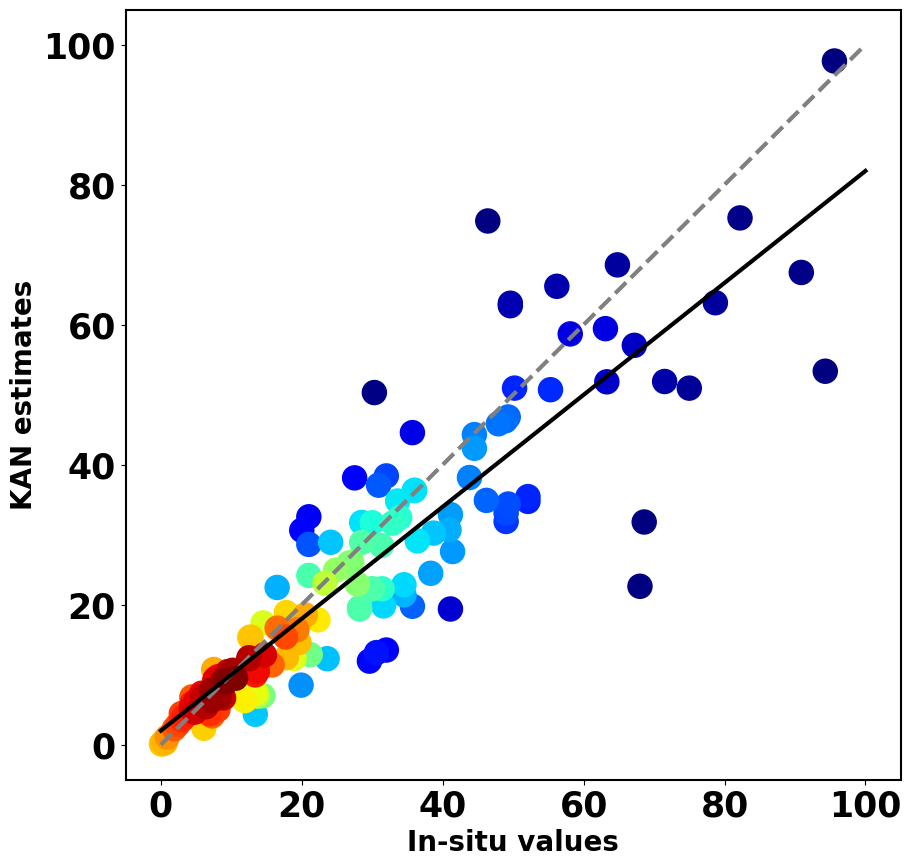

In [43]:
import matplotlib
from scipy.stats import gaussian_kde

filename = "Houston_L89_KAN.jpg"

matplotlib.rcParams['axes.linewidth'] = 1.5

x = np.squeeze(truth_test)
y = np.squeeze(predictions_test)

# refine
# For houston S2- 0.3 and 0.6
# For louisiana S2- 0.4 and 0.7
# For louisiana L89- 0.2 and 0.7
Th = 0.2
for i in range(len(x)):
    orig_err = (y[i] - x[i]) / x[i]
    if abs(orig_err) > 0.7:
        # clamp to ±10% while preserving sign
        if orig_err > 0:
            y[i] = (1+Th) * x[i]  # +10%
        else:
            y[i] = (1-Th) * x[i]  # -10%

# # For louisiana L89
# cond1 = y>20
# cond2 = y<40
# cond3 = x>60
# cond4 = x<80
# y[cond1 * cond2 * cond3 * cond4] = y[cond1 * cond2 * cond3 * cond4] + 12
# cond1 = y>70
# cond2 = y<80
# cond3 = x>40
# cond4 = x<60
# y[cond1 * cond2 * cond3 * cond4] = y[cond1 * cond2 * cond3 * cond4] - 15


mape_test = mape(np.squeeze(x), np.squeeze(y))
r2_test = r_squared(np.squeeze(x), np.squeeze(y))

print('')
print('MAPE = ', mape_test)
print('R2 = ', r2_test)
print('')

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize = (10,10))
ax.plot([0,100], [0,100], color='grey', linestyle='dashed', linewidth=3)

ax.scatter(x, y, c=z, s=300, cmap='jet')

import numpy as np

N = len(x)  # total number of points
estimated_counts = z / np.sum(z) * N
print('counts min: ', np.min(estimated_counts))
print('counts max: ', np.max(estimated_counts))

slope, intercept = np.polyfit(x, y, 1)  # 1 => first-degree polynomial => line
x_line = np.linspace(0, 100, 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='black', linewidth=3, label='Best-fit line')

#ax.set_xlim([0, 100])
#ax.set_ylim([0, 140])

ax.set_xlabel("In-situ values", fontsize=20, fontweight="bold")
ax.set_ylabel("KAN estimates", fontsize=20, fontweight="bold")

plt.xticks(fontsize=25, fontweight='bold');
plt.yticks(fontsize=25, fontweight='bold');

# fig.savefig(filename, dpi=700)

In [45]:
# for taylor plot
np.std(np.squeeze(x))
# np.std(np.squeeze(y))

21.68369

In [23]:
file_path = '/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/WQEye_Mostafa/Train_Test/Turb/Louisiana_L89/Final_outputs_scatterplots/'

np.save(file_path + 'in-situ.npy', x)
np.save(file_path + 'KAN_predictions.npy', y)